In [2]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string

# VEST OH 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Ohio Secretary of State (https://www.sos.state.oh.us/elections/election-results-and-data/). 

#### Processing Part 1
The following counties include adjustments to account for corporate annexations that are not specified below by precinct: Adams, Athens, Butler, Franklin, Guernsey, Montgomery, Stark, Tuscarawas, Warren, Wayne.

#### Processing Part 2 (unclear whether this is for election results, shapefiles, or both)
The following additional revisions were made to match the 2020 precinct boundaries:

- **Athens:** Adjust Athens 4-4/4-5, Nelsonville 1/2/3/4
- **Brown:** Adjust Perry Twp South/Villages
- **Butler:** Adjust Hamilton 22/24, Oxford 6/11, Trenton 5/7, West Chester 28/39
- **Champaign:** Adjust Union N/S
- **Clark:** Align New Carlisle, Springfield precincts with county maps
- **Crawford:** Move eastern Polk Twp from Galion 1B to western Polk Twp
- **Cuyahoga:** Adjust Olmsted Twp D/F/H
- **Delaware:** Adjust Berlin C/Delaware 3-F
- **Fairfield:** Adjust Greenfield B/Lancaster 2-A, Pickerington F/Violet B/Violet C
- **Greene:** Adjust Bath 277/Fairborn 226/Xenia 351
- **Hamilton:** Adjust Cleves A/Whitewater A, Colerain BB/F
- **Knox:** Adjust Clinton A/Mount Vernon 1-B, Clinton B/Mount Vernon 2-A
- **Lake:** Adjust Painesville A/K
- **Medina:** Adjust Wadsworth City 1-D/Sharon D, Wadsworth City 2-D/Twp C
- **Richland:** Adjust Ontario 3/4
- **Stark:** Adjust Canton 8-C/Plain 6, Canton 6-A/Plain 12
- **Summit:** Adjust Coventry D/G, Hudson 1-B/3-C, Springfield F/J
- **Warren:** Adjust Mason City Z/Union A, South Lebanon A/B


### Shapefiles

#### Sources
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. Note that some VTDs were relabeled to match precinct names and/or precinct codes in the November 2020 general election returns.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [3]:
vest_oh_20 = gp.read_file("./raw-from-source/VEST/oh_2020/oh_2020.shp")

In [4]:
vest_oh_20.crs

{'init': 'epsg:4269'}

<AxesSubplot:>

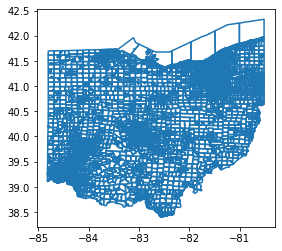

In [5]:
vest_oh_20.boundary.plot()

In [6]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for OH

In [7]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Ohio"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
oh_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Cleaned the `statewideresultsbyprecinct.xlsx` file by hand, and created `statewideresultsbyprecinct_clean.csv`. No modifications were made to the election results. Unnecessary tabs were removed and column names were renamed to match VEST's manually. 

In [14]:
#Load in clean SOS file
elections_2020 = pd.read_csv("./raw-from-source/SOS/statewideresultsbyprecinct_clean.csv")

In [9]:
elections_2020.shape

(8935, 9)

In [10]:
elections_2020.head()

,County Name,Precinct Name,Precinct Code,Registered Voters,Ballots Counted,G20PREDBID,G20PREGHAW,G20PRELJOR,G20PRERTRU
0,Adams,BRATTON TOWNSHIP,AAA,957,738,118,2.0,6.0,605
1,Adams,BRUSH CREEK TOWNSHIP,AAB,773,547,90,4.0,4.0,442
2,Adams,LOCUST GROVE,AAD,719,550,80,1.0,3.0,460
3,Adams,GREEN TOWNSHIP,AAE,401,289,54,0.0,2.0,230
4,Adams,JEFFERSON TOWNSHIP,AAG,498,329,60,0.0,1.0,266


In [11]:
#Map to the correct FIP
elections_2020["county"]=elections_2020["County Name"].map(oh_fips_dict).fillna(elections_2020["County Name"])

#Print out the FIPS to make sure they all are in the correct format
elections_2020["county"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111', '113', '115', '117', '119', '121', '123', '125',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '163', '165', '167', '169', '171', '173', '175', nan], dtype=object)

## Compare Election Results Totals

### Compare Total Votes

In [12]:
races = [x for x in vest_oh_20.columns if 'G20' in x]
races

['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW']

In [15]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_oh_20[i])
    sum_var_2 += np.sum(elections_2020[i])
print(sum_var_1)
print(sum_var_2)

5920380
5920380


### Compare Race Totals

In [16]:
for race in races:
    diff_val = sum(vest_oh_20[race])-sum(elections_2020[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL")

G20PRERTRU: EQUAL
G20PREDBID: EQUAL
G20PRELJOR: EQUAL
G20PREGHAW: EQUAL


# Precinct Shapefile

## Load in the shapefiles

### 2020 TIGER/Line

> Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release

Link to the 2020 TIGER/Line files for Ohio, where we can download the VTD file: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/39_OHIO/39/

In [17]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_39_vtd20/tl_2020_39_vtd20.shp')

In [18]:
tiger_vtd.head(1)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,39,009,005ACR,39009005ACR,A,ATHENS 2-5,ATHENS 2-5,00,G5240,N,128384,1292,+39.3235059,-082.0932670,"POLYGON ((-82.09632 39.32211, -82.09627 39.322..."


In [19]:
tiger_vtd.shape

(8941, 15)

<AxesSubplot:>

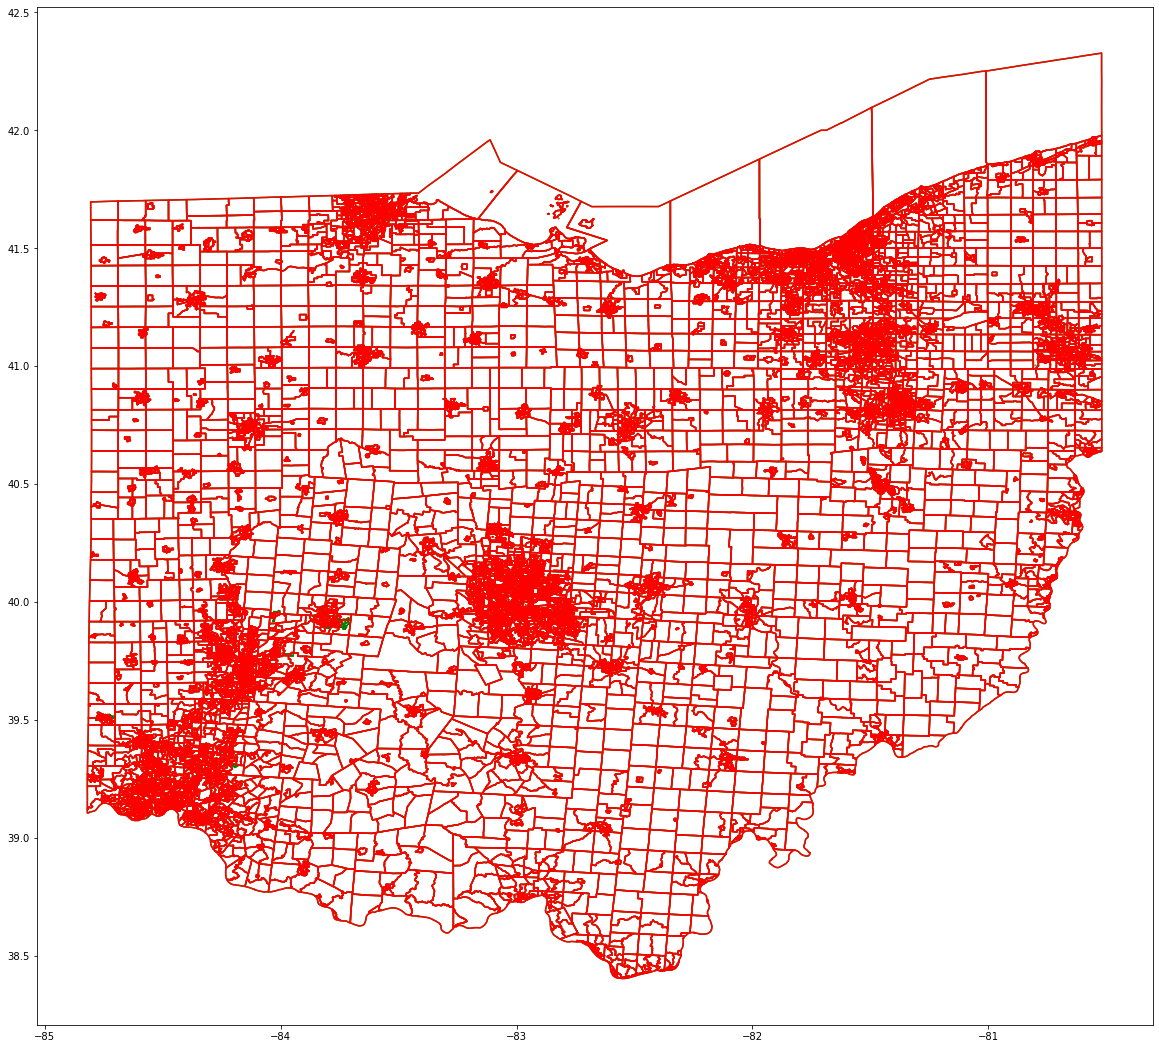

In [20]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(20,20),color="green")
vest_oh_20.boundary.plot(figsize=(20,20),ax=ax,color="red")

With a cursory look, this looks correct. 

In [22]:
merge_shps = pd.merge(tiger_vtd,vest_oh_20,how="outer",left_on="VTDST20",right_on="VTDST20",indicator=True)

In [23]:
both = merge_shps[merge_shps["_merge"]=="both"]
source_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_oh_20.crs)
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_oh_20.crs)
source_geoms = source_geoms.to_crs(epsg=3857)
vest_geoms = vest_geoms.to_crs(epsg=3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     8657
False     340
dtype: int64
